 <font color = 'black' > <font size = '5' >Loading Data and Feature Engineering

This file is to load the initial chosen data to tell whether these variables can fit with each other (say, whether choosing them will reduce the size of the data set tremendously).

In [44]:
# basic python tools for numbers and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# statistics tools
import scipy.stats as stats

# machine learning tools
from sklearn import preprocessing 
# from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

#import xgboost as xgb

from sklearn import metrics

# other tools
from functools import reduce
from imblearn.over_sampling import SMOTE
import itertools
import copy

# Clear warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# show plots inline
%matplotlib inline

In [45]:
def clean_epsilon(cell):
    if cell - 0.0 < 0.0001:
        return 0
    return cell

#### DEMO data

In [46]:
# Load demo data
datadir = 'data/'
demo = pd.read_sas(datadir+'DEMO.XPT')
demo_B = pd.read_sas(datadir+'DEMO_B.XPT')
demo_C = pd.read_sas(datadir+'DEMO_C.XPT')
demo_cols = ['SEQN','RIAGENDR','RIDAGEYR', 'RIDRETH1', 'INDFMINC', 'DMDHREDU','DMDHRMAR']
demo_renamed_cols = ['SEQN', 'gender', 'age', 'race', 'FMincome', 'education', 'marital_status']
demo_file_cols = [(demo,demo_cols),(demo_B,demo_cols),(demo_C,demo_cols)]

In [47]:
# this function replaces zero values, concatenate chosen dfs, and rename the chosen cols 
def concat_rename_dfs(file_cols,renamed_cols,csv_name):
    dfs = pd.DataFrame(columns = renamed_cols)
    for tp in file_cols:
        file = tp[0]
        cols = tp[1]
        df = file[cols]        
        df.columns = renamed_cols
        dfs = pd.concat([dfs, df])                      
    dfs = dfs.applymap(clean_epsilon)                
    dfs.set_index("SEQN", inplace=True)
    dfs = dfs[~dfs.index.duplicated(keep='first')]  # if has duplicated SEQN's, keep the first one 
    # dfs.to_csv(csv_name,index=False,sep=',')
    return dfs
    
dfs_demo = concat_rename_dfs(demo_file_cols,demo_renamed_cols,"dfs_demo.csv")
print(dfs_demo.info())
dfs_demo.head(20)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 31126 entries, 1.0 to 31126.0
Data columns (total 6 columns):
gender            31126 non-null float64
age               31126 non-null float64
race              31126 non-null float64
FMincome          30593 non-null float64
education         30030 non-null float64
marital_status    28487 non-null float64
dtypes: float64(6)
memory usage: 1.7 MB
None


,gender,age,race,FMincome,education,marital_status
SEQN,,,,,,
1.0,2.0,2.0,4.0,3.0,3.0,5.0
2.0,1.0,77.0,3.0,8.0,5.0,NaN
3.0,2.0,10.0,3.0,6.0,4.0,1.0
4.0,1.0,1.0,4.0,3.0,3.0,4.0
5.0,1.0,49.0,3.0,11.0,4.0,1.0
6.0,2.0,19.0,5.0,3.0,4.0,5.0
7.0,2.0,59.0,4.0,NaN,2.0,1.0
8.0,1.0,13.0,3.0,3.0,1.0,3.0
9.0,2.0,11.0,4.0,99.0,2.0,4.0


## Dealing with missing values
- Get missing values information
    1. Get the ratio of missing values
    2. Visualize abundances of missing values between different features 
    
    
- Fill or predict missing values 
    1. Fill NaN will mean/mode
    2. Predict NaN with random forest 
    3. 

### Get missing values information 

In [48]:
def get_NaN_ratio(dfs,col_name):
    total_count = dfs.shape[0]              # total entries
    col_valid_count = dfs[col_name].count() # valid entries for chosen col
    col_null_count = total_count - col_valid_count
    NaN_ratio = col_null_count/total_count
    print('The NaN ratio in',col_name,'is',"%.3f" % NaN_ratio)
    if NaN_ratio <= 0.1:
        print('Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category')
        print('Now call function: fill_NaN(dfs, col_name, fill_type)')
        print()
    else:
        print('Since NaN ratio is large, predict NaN using ML...')
        print('Now call function: predict_NaN_with_ML(dfs,x,y,data_type,model)')
        print()
    

####################################################################################    
   
def plot_NaN_abundance(dfs):
    #  reset the index, the old index is added as a column, and a new sequential index is used
    tot = dfs.shape[0]
    missing_df = dfs.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df = missing_df.sort_values(by='missing_count')

    ind = np.arange(missing_df.shape[0])
    y = missing_df.missing_count.values
    fig, ax = plt.subplots() 
    rects = ax.barh(ind, y, color='blue')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    for i, v in enumerate(y):
        ax.text(v + 3, i - 0.1, str(v)+'/'+str(tot), color='red')
    plt.show()

####################################################################################    
# function: plot_heat_map
# purpose:  See which variables are 'potentially' redundant. 
#           The strongly correlated variables can be seen by the dark red path.
#           They represent very similair pieces of information.
#           Pick the one with the fewest number of missing values and drop the rest. 
# input:    dfs, numcols: all cols in dfs that are numericals
# note:     use this function when there are already many numberical cols 
 

def plot_heat_map(dfs,numcols):
    allcols = dfs.columns.values.tolist()
    catcols = [x for x in allcols if x not in numcols]
    plt.figure() 
    sns.heatmap(data=dfs[numcols].corr())
    plt.show()
    plt.gcf().clear()

####################################################################################    

def plot_before_after_fill_NaN(before,after,col_name):
    print('before filling NaN, valid entries of ',col_name,'is ',len(before))
    print('after filling NaN, valid entries of ',col_name,'is ',len(after))
    fig, (ax1,ax2) = plt.subplots(2, sharex = True, sharey=True, tight_layout=True)
    ax1.hist(before, bins=50)
    ax2.hist(after, bins=50)
    ax1.set_title('before fill NaN ' + col_name)
    ax2.set_title('after fill NaN ' + col_name)
    

### Fill or predict missing values

before filling NaN, valid entries of  FMincome is  30593
after filling NaN, valid entries of  FMincome is  31126
<class 'pandas.core.frame.DataFrame'>
Float64Index: 31126 entries, 1.0 to 31126.0
Data columns (total 6 columns):
gender            31126 non-null float64
age               31126 non-null float64
race              31126 non-null float64
FMincome          31126 non-null float64
education         30030 non-null float64
marital_status    28487 non-null float64
dtypes: float64(6)
memory usage: 1.7 MB


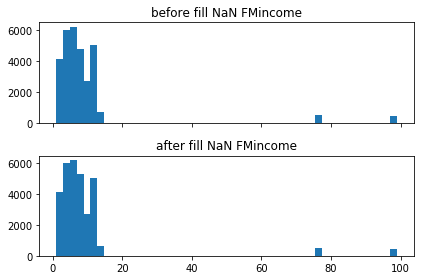

In [49]:
def fill_NaN(dfs, col_name, fill_type):    
    before_filling = dfs[col_name].dropna()
    if fill_type == 'mean':
        after_filling = dfs[col_name].fillna(dfs[col_name].dropna().mean())
    elif fill_type == 'mode':
        after_filling = dfs[col_name].fillna(dfs[col_name].dropna().mode().iloc[0]) 
    else:
        # fill type == 'as new type'
        # set missing values as another category 
        # cannot set this new cat as 0 since there could be 0 after applying clean_epsilon function  
        # need to get a unique number representing NaN as a new category 
        new_type = max(dfs[col_name]) + 1
        after_filling = dfs[col_name].fillna(new_type)   
    # see change in distribution by plotting before and after filling NaN
    dfs[col_name] = after_filling
    plot_before_after_fill_NaN(before_filling,after_filling,col_name)     
    return dfs

dfs_demo = fill_NaN(dfs_demo,'FMincome','mean') 
dfs_demo.info()

In [50]:
#### We use linear regression model to tell whether there is any relationship between the columns that are 
# already processed and the new column to be checked

def check_predictibility(dfs,y):
    
    y_index = dfs.columns.tolist().index(y)
    df_x = dfs.iloc[:,0:y_index]
    df_y= pd.DataFrame(dfs[y].dropna())           # y will have fewer SEQN
    proof1 = pd.merge(df_x, df_y, left_index = True, right_index = True)
    x_reg = proof1.iloc[:,0:y_index]              # all processed cols 
    y_reg = proof1.iloc[:,y_index]                # col to be checked 
    lr = linear_model.LinearRegression()
    lr.fit(x_reg, y_reg)
    z_reg = lr.predict(x_reg)
    
    print('Now checking the predictability of',y,'using Linear Regression...')
    print()
    print('Features are:',df_x.columns.values)
    print('Coefficients for features:', lr.coef_)
    print('Intercept Value:', lr.intercept_)
    print("Mean squared error:",np.mean((z_reg - y_reg) ** 2))
    print("R^2:", lr.score(x_reg, y_reg))
    print()
    
    coeff_list = lr.coef_.tolist()
    max_coeff_idx = lr.coef_.tolist().index(max(lr.coef_))
    max_coeff_x = x_reg.columns.values[max_coeff_idx]
    x1_reg = pd.DataFrame(proof1[max_coeff_x])
    lr1 = linear_model.LinearRegression()
    lr1.fit(x1_reg,y_reg)
    z1_reg = lr1.predict(x1_reg)
    print('Now check for',y,'and feature with the highest coefficient')
    print('Feature is:',max_coeff_x)
    print('Intercept Value:', lr1.intercept_)
    print('Coefficients:', lr1.coef_)
    print("Mean squared error:",np.mean((z1_reg - y_reg) ** 2))
    print("R^2:", lr1.score(x1_reg, y_reg))
    

### Predict using non-parametric algorithms:
Three non-parametric algorithms, were reported as the foremost classifiers at producing high accuracies.
- Random Forest (RF), 
- k-Nearest Neighbor (kNN), 
- Support Vector Machine (SVM), 

Also see scikit-learn alogorithm cheat sheet
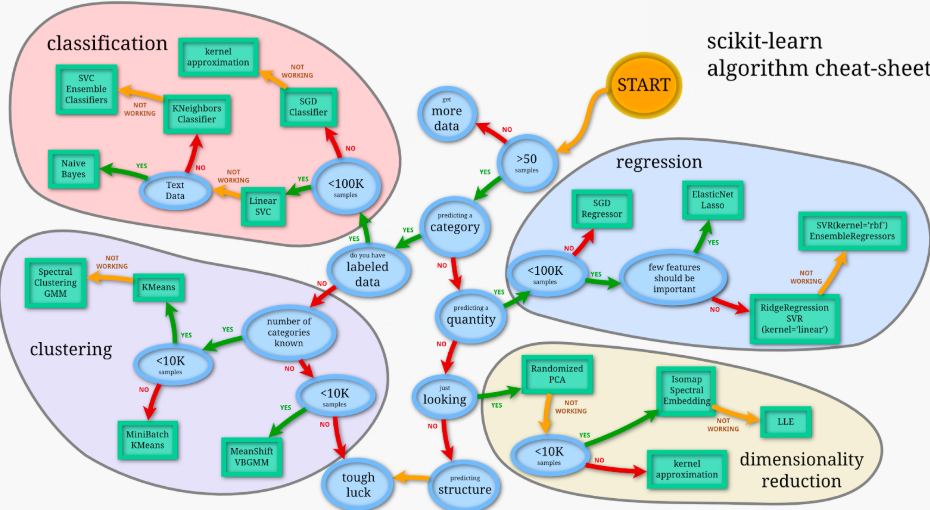

Now checking the predictability of education using Linear Regression...

Features are: ['gender' 'age' 'race' 'FMincome']
Coefficients for features: [-0.0022767  -0.00154738  0.31089552  0.00451517]
Intercept Value: 2.2738323604195547
Mean squared error: 1.7576126545066775
R^2: 0.07745641881111354

Now check for education and feature with the highest coefficient
Feature is: race
Intercept Value: 2.266956721171879
Coefficients: [0.30952299]
Mean squared error: 1.7628510607313823
R^2: 0.07470686075246347

Predict the missing values of education using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome']
The number of predicted values: 1096
before filling NaN, valid entries of  education is  30030
after filling NaN, valid entries of  education is  31126

Predict the missing values of marital_status using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome', 'education']
The number of predicted values: 2639
before filling NaN, valid e

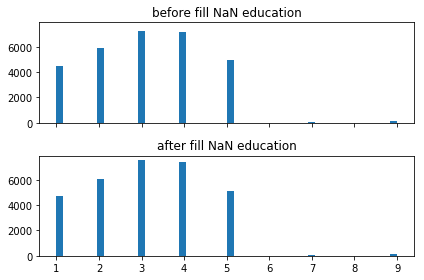

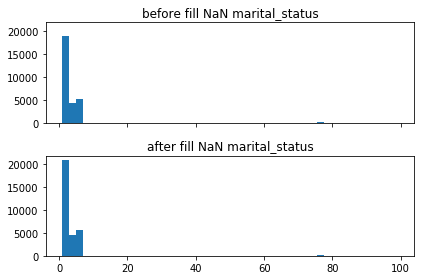

In [51]:
def predict_NaN_with_ML(dfs,x,y,data_type,model):
    print()
    before_filling = dfs[y].dropna()
    
    dfs_valid_entries = dfs[dfs[y].notnull()]               # valid entries where y is not null 
    dfs_valid_entries_x = dfs_valid_entries[x]              # valid entries x
    dfs_valid_entries_y = dfs_valid_entries[y]              # valid entries y
    dfs_valid_entries_x = dfs_valid_entries_x.astype(float) # change data type to float
    dfs_valid_entries_y = dfs_valid_entries_y.astype(float)
    
    if data_type == 'categorical':
        if model == 'random forest':
            algo = RandomForestClassifier()
        elif model == 'linear SVC':
            algo = LinearSVC()
        elif model == 'knn':
            algo = KNeighborsClassifier(n_neighbors=3)
        else: 
            print('The model is not defined, add this model now!')
        print('Predict the missing values of',y,'using ',model,' Classifier...')

    else: # data_type == 'numerical' 
        if model == 'random forest':
             algo = RandomForestRegressor()
        elif model == 'SVR':
            algo = SVR()
        elif model == 'knn':
            algo = KNeighborsRegressor(n_neighbors=2)
        else: 
            print('The model is not defined, add this model now!')
        print('Predict the missing values of',y,'using ',model,' Regressor...')

    
    algo.fit(dfs_valid_entries_x, dfs_valid_entries_y)        # build fc model using valid entries x & y   
    dfs_nan_entries = dfs[dfs[y].isnull()]                  # entries where y is null     
    dfs_nan_entries_x = dfs_nan_entries[x].astype(float)    
    dfs_nan_entries_y = dfs_nan_entries[y].astype(float)
    predict_y = algo.predict(dfs_nan_entries_x)               # predict NaN y based on x on the same entries    
    dfs.loc[(dfs[y].isnull()), y] = predict_y               # Fill the missing values with predicted data
    
    print('Features are:',x)
    print('The number of predicted values:',len(predict_y))
    
    after_filling = dfs[y]
    plot_before_after_fill_NaN(before_filling,after_filling,y)     
    
    
    
check_predictibility(dfs_demo,'education')
x_for_education = ['gender', 'age', 'race', 'FMincome']
predict_NaN_with_ML(dfs_demo,x_for_education,'education','categorical','random forest')
x_for_marital_status = ['gender', 'age', 'race', 'FMincome', 'education']
predict_NaN_with_ML(dfs_demo,x_for_marital_status,'marital_status','categorical','random forest')
dfs_demo.info()

#### Alcohol data

In [52]:
# Load alco data
alco = pd.read_sas(datadir+'ALQ.XPT')
alco_B = pd.read_sas(datadir+'ALQ_B.XPT')
alco_C = pd.read_sas(datadir+'ALQ_C.XPT')
alco_cols = ['SEQN', 'ALQ100', 'ALQ120Q', 'ALQ120U']
alco_B_cols = ['SEQN', 'ALD100', 'ALQ120Q', 'ALQ120U']
alco_C_cols = ['SEQN', 'ALQ101', 'ALQ120Q', 'ALQ120U']
alco_renamed_cols = ['SEQN','freq:12 drinks/yr?','alco_freq_num','alco_freq_cat']
alco_file_cols = [(alco,alco_cols),(alco_B,alco_B_cols),(alco_C,alco_C_cols)]

dfs_alco = concat_rename_dfs(alco_file_cols,alco_renamed_cols,"dfs_alco.csv")
print(dfs_alco.info())
print(dfs_alco.describe())
dfs_alco.head(10)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 14213 entries, 2.0 to 31125.0
Data columns (total 3 columns):
freq:12 drinks/yr?    13094 non-null float64
alco_freq_num         11094 non-null float64
alco_freq_cat         8325 non-null float64
dtypes: float64(3)
memory usage: 444.2 KB
None
       freq:12 drinks/yr?  alco_freq_num  alco_freq_cat
count        13094.000000   11094.000000    8325.000000
mean             1.327020       5.290247       1.937177
std              0.491406      38.080096       0.866105
min              1.000000       0.000000       1.000000
25%              1.000000       1.000000       1.000000
50%              1.000000       2.000000       2.000000
75%              2.000000       3.000000       3.000000
max              9.000000     999.000000       3.000000


,freq:12 drinks/yr?,alco_freq_num,alco_freq_cat
SEQN,,,
2.0,1.0,24.0,3.0
5.0,1.0,4.0,1.0
7.0,2.0,NaN,NaN
10.0,1.0,6.0,3.0
12.0,1.0,2.0,2.0
13.0,1.0,1.0,1.0
14.0,1.0,1.0,1.0
15.0,1.0,4.0,1.0
16.0,2.0,NaN,NaN


In [53]:
# df1 = dfs_demo + dfs_alco 
df1 = pd.merge(dfs_demo, dfs_alco, on = 'SEQN', left_index = True, sort = False)
# df2 = pd.merge(dfs_demo, dfs_alco, left_index = True, right_index = True)
# df1.info()

### !! ###
I tried run linear regression with all features and with strongly correlated features(with higher coefficients). Mean squared error does not vary much. So I will use all variables for prediction for now.

In [54]:
df1_cols = df1.columns.values.tolist()
print(df1_cols)
check_predictibility(df1,'freq:12 drinks/yr?')

['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?', 'alco_freq_num', 'alco_freq_cat']
Now checking the predictability of freq:12 drinks/yr? using Linear Regression...

Features are: ['gender' 'age' 'race' 'FMincome' 'education' 'marital_status']
Coefficients for features: [ 2.76184206e-01  2.60134201e-03  1.81734485e-02  1.43979260e-04
 -3.50880715e-02 -1.08274464e-03]
Intercept Value: 0.8397781263281423
Mean squared error: 0.2176987297986788
R^2: 0.0984132337688277

Now check for freq:12 drinks/yr? and feature with the highest coefficient
Feature is: gender
Intercept Value: 0.9137513632405596
Coefficients: [0.27189929]
Mean squared error: 0.223008830139926
R^2: 0.07642175867173884



Predict the missing values of freq:12 drinks/yr? using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status']
The number of predicted values: 1119
before filling NaN, valid entries of  freq:12 drinks/yr? is  13094
after filling NaN, valid entries of  freq:12 drinks/yr? is  14213


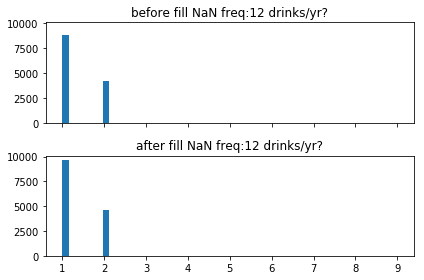

In [55]:
# Similar as before, it is predictable, but not strongly correlated.
# We still use random forest to predict the missing values.
x_for_freq12drinks = ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status']
predict_NaN_with_ML(df1,x_for_freq12drinks,'freq:12 drinks/yr?','categorical','random forest')

In [56]:
df1.head(10)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 14213 entries, 2.0 to 31125.0
Data columns (total 9 columns):
gender                14213 non-null float64
age                   14213 non-null float64
race                  14213 non-null float64
FMincome              14213 non-null float64
education             14213 non-null float64
marital_status        14213 non-null float64
freq:12 drinks/yr?    14213 non-null float64
alco_freq_num         11094 non-null float64
alco_freq_cat         8325 non-null float64
dtypes: float64(9)
memory usage: 1.7 MB


### !!!
Now we proceed to deal with ALQ120Q & 120U.
- ALQ120Q: alco_freq_num - How often drink alcohol over past 12 mos
- ALQ120U: alco_freq_cat - # days drink alcohol per wk, mo, yr (1:week,2:month,3:year)

Combine these two variables into one variable: 
- alco_freq_year: the number of days that you drink in a year

        1 - week:   ALQ120Q * 54.143 (weeks/yr)
        2 - month:  ALQ120Q * 12     (months/yr)
        3 - year:   ALQ120Q * 1

After converting to the same scale, we then predict this new feature [alco_freq_year] using [freq:12 drinks/yr?].


In [57]:
df1[['alco_freq_num','alco_freq_cat']].head(100)
df1.head(50)

zeros = np.zeros(shape=(len(df1.index),1))
df1['alco_freq_year'] = zeros
df1.head(10)


,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_num,alco_freq_cat,alco_freq_year
SEQN,,,,,,,,,,
2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.0,3.0,0.0
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,4.0,1.0,0.0
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,NaN,NaN,0.0
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.0,3.0,0.0
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,2.0,2.0,0.0
13.0,1.0,70.0,1.0,3.000000,1.0,1.0,1.0,1.0,1.0,0.0
14.0,1.0,81.0,3.0,5.000000,2.0,3.0,1.0,1.0,1.0,0.0
15.0,2.0,38.0,3.0,8.000000,5.0,3.0,1.0,4.0,1.0,0.0
16.0,2.0,85.0,4.0,1.000000,1.0,2.0,2.0,NaN,NaN,0.0


In [58]:
for SEQN,category in df1['alco_freq_cat'].iteritems():
    alco_freq_num = df1.loc[SEQN]['alco_freq_num']
    if category == 1:   # week
        drinks = alco_freq_num * (365/7)
    elif category == 2: # month 
        drinks = alco_freq_num * (12)
    elif category == 3: # year
        drinks = alco_freq_num
    else:              # NaN: doing nothing for now
        drinks = np.nan  
    df1.set_value(SEQN,'alco_freq_year',drinks)

df1 = df1.drop(['alco_freq_num','alco_freq_cat'], axis=1)
df1.info()
df1.head(20)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 14213 entries, 2.0 to 31125.0
Data columns (total 8 columns):
gender                14213 non-null float64
age                   14213 non-null float64
race                  14213 non-null float64
FMincome              14213 non-null float64
education             14213 non-null float64
marital_status        14213 non-null float64
freq:12 drinks/yr?    14213 non-null float64
alco_freq_year        8325 non-null float64
dtypes: float64(8)
memory usage: 1.6 MB


,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year
SEQN,,,,,,,,
2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.000000
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,208.571429
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,NaN
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.000000
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,24.000000
13.0,1.0,70.0,1.0,3.000000,1.0,1.0,1.0,52.142857
14.0,1.0,81.0,3.0,5.000000,2.0,3.0,1.0,52.142857
15.0,2.0,38.0,3.0,8.000000,5.0,3.0,1.0,208.571429
16.0,2.0,85.0,4.0,1.000000,1.0,2.0,2.0,NaN


Now checking the predictability of alco_freq_year using Linear Regression...

Features are: ['gender' 'age' 'race' 'FMincome' 'education' 'marital_status'
 'freq:12 drinks/yr?']
Coefficients for features: [-3.74473304e+01  9.94403174e-01  7.27191420e+00  2.46528775e-02
  3.46012954e+00  2.21930338e-02 -6.53608786e+01]
Intercept Value: 125.84764967403508
Mean squared error: 9555.417044536427
R^2: 0.12701704930462965

Now check for alco_freq_year and feature with the highest coefficient
Feature is: race
Intercept Value: 53.58478959944091
Coefficients: [8.27209492]
Mean squared error: 10866.914161706363
R^2: 0.007198665885143619

Predict the missing values of alco_freq_year using  random forest  Regressor...
Features are: ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?']
The number of predicted values: 5888
before filling NaN, valid entries of  alco_freq_year is  8325
after filling NaN, valid entries of  alco_freq_year is  14213


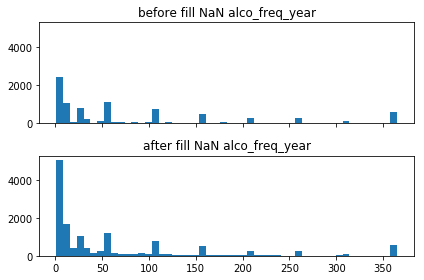

In [59]:
x_for_alco_freq_year = ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?']

check_predictibility(df1,'alco_freq_year')
predict_NaN_with_ML(df1,x_for_alco_freq_year,'alco_freq_year','numerical','random forest')

Pearson correlation coefficient:
- A measure of the linear correlation between two variables X and Y. Has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

In [60]:
df1.describe()
stats.pearsonr(df1['freq:12 drinks/yr?'], df1['alco_freq_year'])

(-0.38939282360586336, 0.0)

### Pain Killers (PK)

In [61]:
# Load PK data
RXQANA = pd.read_sas(datadir+'RXQ_ANA.XPT')
RXQANA_B = pd.read_sas(datadir+'RXQANA_B.XPT')
RXQANA_C = pd.read_sas(datadir+'RXQANA_C.XPT')

PK_cols = ['SEQN', 'RXQ300', 'RXQ330']
PK_B_cols = ['SEQN', 'RXD300', 'RXD330']
PK_C_cols = ['SEQN', 'RXD300', 'RXD330']
PK_renamed_cols = ['SEQN', 'regular PK use', 'current PK use']
PK_file_cols = [(RXQANA,PK_cols),(RXQANA_B,PK_B_cols),(RXQANA_C,PK_C_cols)]
dfs_pk = concat_rename_dfs(PK_file_cols,PK_renamed_cols,"dfs_pk.csv")
print(dfs_pk.info())
print(dfs_pk.describe())
dfs_pk.head(20)


<class 'pandas.core.frame.DataFrame'>
Float64Index: 15332 entries, 2.0 to 31125.0
Data columns (total 2 columns):
regular PK use    15316 non-null float64
current PK use    3581 non-null float64
dtypes: float64(2)
memory usage: 359.3 KB
None
       regular PK use  current PK use
count    15316.000000     3581.000000
mean         1.777879        1.352974
std          0.506332        0.575049
min          1.000000        1.000000
25%          2.000000        1.000000
50%          2.000000        1.000000
75%          2.000000        2.000000
max          9.000000        9.000000


,regular PK use,current PK use
SEQN,,
2.0,1.0,1.0
5.0,2.0,NaN
7.0,2.0,NaN
10.0,1.0,1.0
12.0,1.0,2.0
13.0,2.0,NaN
14.0,2.0,NaN
15.0,2.0,NaN
16.0,2.0,NaN


Now checking the predictability of regular PK use using Linear Regression...

Features are: ['gender' 'age' 'race' 'FMincome' 'education' 'marital_status'
 'freq:12 drinks/yr?' 'alco_freq_year']
Coefficients for features: [-0.02458216 -0.00664531 -0.00977432  0.00100314 -0.01286153  0.00521365
  0.01711843 -0.00016126]
Intercept Value: 2.1747836979176998
Mean squared error: 0.20268934372063055
R^2: 0.08115407306652234

Now check for regular PK use and feature with the highest coefficient
Feature is: freq:12 drinks/yr?
Intercept Value: 1.7762898205540265
Coefficients: [-0.00333836]
Mean squared error: 0.22058846327858933
R^2: 1.2495519231547902e-05

Predict the missing values of regular PK use using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?', 'alco_freq_year']
The number of predicted values: 11
before filling NaN, valid entries of  regular PK use is  14202
after filling NaN, valid entries of  regu

,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year,regular PK use,current PK use
count,14213.000000,14213.000000,14213.000000,14213.00000,14213.000000,14213.000000,14213.000000,14213.000000,14213.000000,14213.000000
mean,1.526138,49.766481,2.769648,8.69194,3.174629,2.269612,1.326110,62.068970,1.771969,1.388025
std,0.499334,19.133925,1.110609,13.32414,1.389888,3.964439,0.497353,90.799339,0.469590,0.513061
min,1.000000,20.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,33.000000,2.000000,4.00000,2.000000,1.000000,1.000000,4.300000,2.000000,1.000000
50%,2.000000,48.000000,3.000000,6.00000,3.000000,1.000000,1.000000,21.857143,2.000000,1.000000
75%,2.000000,66.000000,3.000000,10.00000,4.000000,3.000000,2.000000,84.714286,2.000000,2.000000
max,2.000000,85.000000,5.000000,99.00000,9.000000,99.000000,9.000000,365.000000,9.000000,9.000000


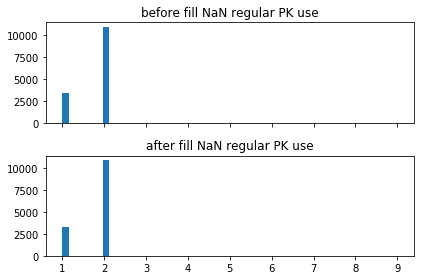

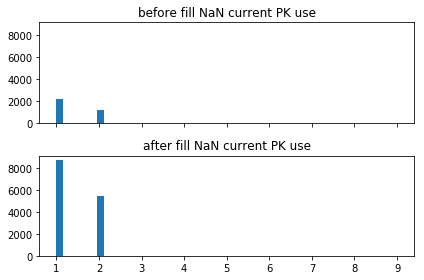

In [62]:
# df2 = df1 + dfs_pk = (dfs_demo + dfs_alco) + dfs_pk
df2 = pd.merge(df1, dfs_pk, on = 'SEQN', left_index =  True, sort = False)
check_predictibility(df2,'regular PK use')
x_for_regular_pk_use = ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status','freq:12 drinks/yr?', 'alco_freq_year']
predict_NaN_with_ML(df2,x_for_regular_pk_use,'regular PK use','categorical','random forest')
# df2.describe()
check_predictibility(df2,'current PK use')
x_for_current_pk_use = ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status','freq:12 drinks/yr?', 'alco_freq_year','regular PK use']
predict_NaN_with_ML(df2,x_for_current_pk_use,'current PK use','categorical','random forest')
df2.describe()


- Create a new variable named pk_use combining regular and current pk use:
To see what combinations of regular and current pk uses are possible, check for possible values in both cols

In [63]:
print('unique values in regular PK use:', df2['regular PK use'].unique())
print('unique values in current PK use:', df2['current PK use'].unique())

unique values in regular PK use: [1. 2. 7. 9.]
unique values in current PK use: [1. 2. 7. 9.]


- code words for the new variable pk use: 

| Regular pk use | Current pk use | pk use | pk use code explanation                             |
|----------------|----------------|--------|-----------------------------------------------------|
| yes 1          | yes 1          | 1      | take both regularly in the past and the present     |
| yes 1          | no 2           | 2      | taken regularly in the past but not in the present  |
| no 2           | yes 1          | 3      | didn't take regularly in the past but is taking now |
| no 2           | no 2           | 4      | never take the pain killers                         |
| if 7/9         | if 7/9         | 5      | if either contains refuse or don't know             |

* note for the last row in the table: if either of regular or current pk use contains 7 or 9, assign 5 as pk use

In [64]:
for SEQN,row in df2.iterrows():
    regular = row['regular PK use']
    current = row['current PK use']
    if regular == 1 and current == 1:
        pk_use = 1
    elif regular == 1 and current == 2:
        pk_use = 2
    elif regular == 2 and current == 1:
        pk_use = 3
    elif regular == 2 and current == 2:
        pk_use = 4
    else:
        pk_use = 5 
    df2.set_value(SEQN,'pk use',pk_use)
df2.head(5)

,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year,regular PK use,current PK use,pk use
SEQN,,,,,,,,,,,
2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.000000,1.0,1.0,1.0
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,208.571429,2.0,1.0,3.0
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,12.228571,2.0,1.0,3.0
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.000000,1.0,1.0,1.0
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,24.000000,1.0,2.0,2.0


In [65]:
df2 = df2.drop(['regular PK use','current PK use'], axis=1)
df2.head()

,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year,pk use
SEQN,,,,,,,,,
2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.000000,1.0
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,208.571429,3.0
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,12.228571,3.0
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.000000,1.0
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,24.000000,2.0


## TO DO: CSTR VALUES

### Blood Pressure(BP) & Blood Cholesterol(BC)

1. Modification: change 'ever check BC' to 'told if has high BC'
2. Physiologically, high cholesterol level(blood vessel narrowing due to plaque buildup) could lead to high blood pressure, but this is not always the case. It's better to treat these two as two separate variables for now.
3. Group weight control (now controlling weight) and weight control own (controlling weight on own will) into one variable. Same for increasing exercise and taking medicines. 

#### 1: Modification

In [66]:
# Load BP data
BPQ = pd.read_sas(datadir+'BPQ.XPT')
BPQ_B = pd.read_sas(datadir+'BPQ_B.XPT')
BPQ_C = pd.read_sas(datadir+'BPQ_C.XPT')
col_1 = ['SEQN', 'BPQ020', 'BPQ080', 'BPQ100D','BPQ100A', 'BPQ100B','BPQ100C', 'BPQ110A', 'BPQ110B', 'BPQ110C']
col_2 = ['SEQN', 'BPQ020', 'BPQ080', 'BPQ100D','BPQ100A', 'BPQ100B','BPQ100C', 'BPD110A', 'BPD110B', 'BPD110C']
BPQ_renamed_cols = ['SEQN','high BP','high BC','take med','low cal diet','weight control','inc exercise','low cal diet own','weight control own','inc exercise own']
BPQ_file_cols = [(BPQ,col_1),(BPQ_B,col_2),(BPQ_C,col_2)]
dfs_bp = concat_rename_dfs(BPQ_file_cols,BPQ_renamed_cols,"dfs_bp.csv")
print(dfs_bp.info())
dfs_bp.head(20)


<class 'pandas.core.frame.DataFrame'>
Float64Index: 18891 entries, 2.0 to 31125.0
Data columns (total 9 columns):
high BP               18623 non-null float64
high BC               10284 non-null float64
take med              2157 non-null float64
low cal diet          3257 non-null float64
weight control        2147 non-null float64
inc exercise          2583 non-null float64
low cal diet own      11315 non-null float64
weight control own    11315 non-null float64
inc exercise own      11315 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB
None


,high BP,high BC,take med,low cal diet,weight control,inc exercise,low cal diet own,weight control own,inc exercise own
SEQN,,,,,,,,,
2.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0
5.0,1.0,1.0,NaN,1.0,2.0,1.0,NaN,NaN,NaN
6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
10.0,2.0,NaN,NaN,NaN,NaN,NaN,9.0,9.0,9.0
12.0,1.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0
13.0,1.0,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN
14.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0
15.0,2.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN


#### 2. Check high BP & high BC correlation

In [67]:
dfs_bp1 = dfs_bp[['high BP','high BC']].dropna()
same_ratio_bp_bc = (dfs_bp1[dfs_bp1['high BP'] == dfs_bp1['high BC']].shape[0])/(dfs_bp1.shape[0])
print('percentage of bp = bc:',same_ratio_bp_bc)
print()
check_predictibility(dfs_bp1,'high BC')

percentage of bp = bc: 0.6110138159174937

Now checking the predictability of high BC using Linear Regression...

Features are: ['high BP']
Coefficients for features: [0.13068124]
Intercept Value: 1.4647844908714478
Mean squared error: 0.7344296804346901
R^2: 0.007383081443445683

Now check for high BC and feature with the highest coefficient
Feature is: high BP
Intercept Value: 1.4647844908714478
Coefficients: [0.13068124]
Mean squared error: 0.7344296804346901
R^2: 0.007383081443445683


- Predict relationship between categorical variables: 
    - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    - function cramers_v: the output is in the range of [0,1], where 0 means no association and 1 is full association.

In [68]:
# x and y are df columns
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

bp = dfs_bp1['high BP']
bc = dfs_bp1['high BC']
print('The association(correlation for categorical variables) between BP and BC is:', cramers_v(bc,bp))

The association(correlation for categorical variables) between BP and BC is: 0.14171676905822417



Predict the missing values of high BP using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?', 'alco_freq_year', 'pk use']
The number of predicted values: 132
before filling NaN, valid entries of  high BP is  14081
after filling NaN, valid entries of  high BP is  14213

Predict the missing values of high BC using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?', 'alco_freq_year', 'pk use', 'high BP']
The number of predicted values: 4705
before filling NaN, valid entries of  high BC is  9508
after filling NaN, valid entries of  high BC is  14213

Predict the missing values of take med using  random forest  Classifier...
Features are: ['gender', 'age', 'race', 'FMincome', 'education', 'marital_status', 'freq:12 drinks/yr?', 'alco_freq_year', 'pk use', 'high BP', 'high BC']
The number of predicted values: 12205
before fil

,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year,pk use,high BP,high BC,take med,low cal diet,weight control,inc exercise,low cal diet own,weight control own,inc exercise own
SEQN,,,,,,,,,,,,,,,,,,
2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.000000,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,208.571429,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,12.228571,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.000000,1.0,2.0,2.0,2.0,1.0,1.0,1.0,9.0,9.0,9.0
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,24.000000,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0


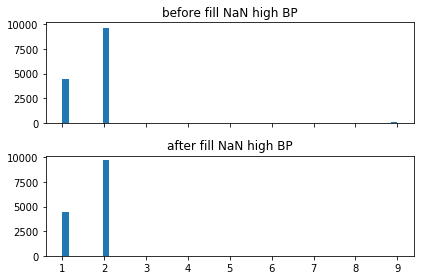

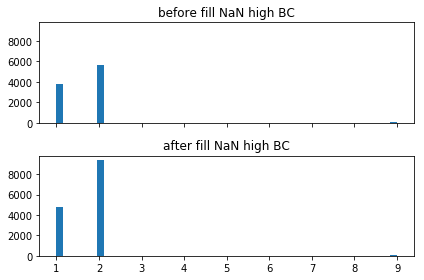

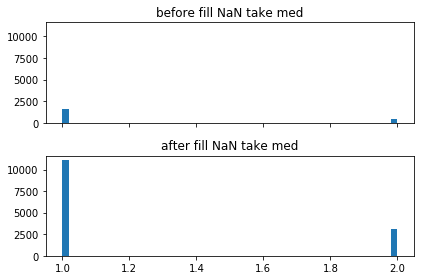

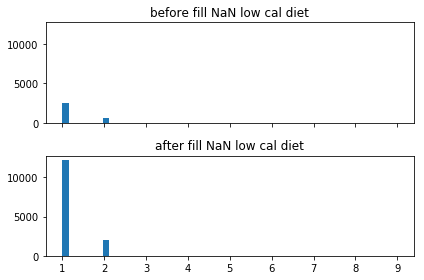

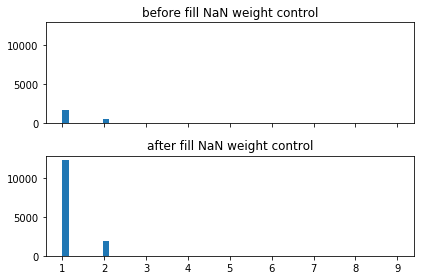

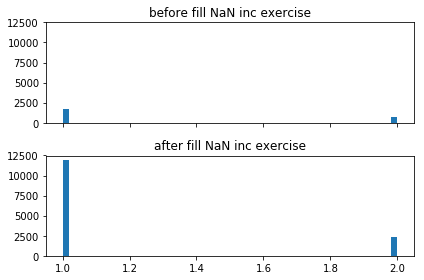

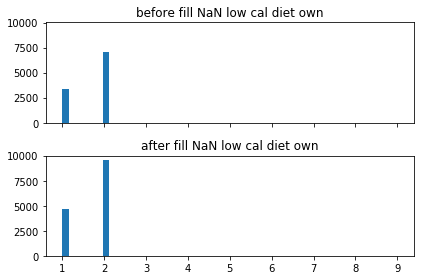

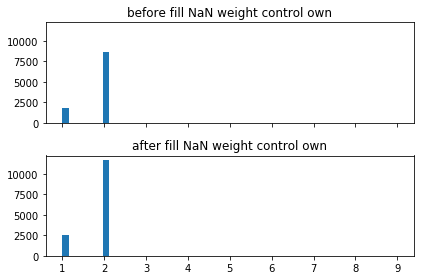

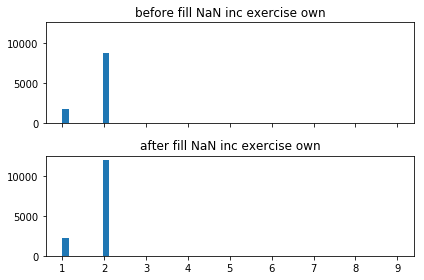

In [69]:
# merge BPQ into previous df and fill NaN
# df3 = df1 + df2 + df3 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp

df3 = pd.merge(df2, dfs_bp, on = 'SEQN', left_index =  True, sort = False)

def fill_NaN_with_rf(df,y,data_type,model):        
    df_cols = df.columns.values.tolist()
    x_for_y = df_cols[:df_cols.index(y)] 
    predict_NaN_with_ML(df,x_for_y,y,data_type,model)
    
fill_NaN_with_rf(df3,'high BP','categorical','random forest')
fill_NaN_with_rf(df3,'high BC','categorical','random forest')
fill_NaN_with_rf(df3,'take med', 'categorical','random forest')

fill_NaN_with_rf(df3,'low cal diet','categorical','random forest')
fill_NaN_with_rf(df3,'weight control','categorical','random forest')
fill_NaN_with_rf(df3,'inc exercise', 'categorical','random forest')

fill_NaN_with_rf(df3,'low cal diet own', 'categorical','random forest')
fill_NaN_with_rf(df3,'weight control own','categorical','random forest')
fill_NaN_with_rf(df3,'inc exercise own', 'categorical','random forest')

print(df3.info())
df3.head(5)

In [70]:
# if any of the variable is 1, whether the behavior is initiated by self or not, assign status to 1

def BP_group_variables(dfs,new_v,old_v1,old_v2):
    dfs[new_v] = 0 
    dfs[new_v][dfs[old_v1] == 1] = 1
    dfs[new_v][dfs[old_v2] == 1] = 1
    dfs = dfs.drop([old_v1,old_v2], axis=1)
    return dfs

df3_1 = BP_group_variables(df3,'diet_status','low cal diet','low cal diet own')
df3_2 = BP_group_variables(df3_1,'weight_status','weight control','weight control own')
df3_3 = BP_group_variables(df3_2,'exercise_status','inc exercise','inc exercise own')
df3 = df3_3
df3.head(20)

,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year,pk use,high BP,high BC,take med,diet_status,weight_status,exercise_status
SEQN,,,,,,,,,,,,,,,
2.0,1.0,77.0,3.0,8.000000,5.0,1.0,1.0,24.000000,1.0,2.0,2.0,1.0,1,1,1
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,208.571429,3.0,1.0,1.0,1.0,1,0,1
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,12.228571,3.0,1.0,1.0,1.0,1,1,1
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.000000,1.0,2.0,2.0,2.0,1,1,1
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,24.000000,2.0,1.0,2.0,1.0,1,0,0
13.0,1.0,70.0,1.0,3.000000,1.0,1.0,1.0,52.142857,3.0,1.0,1.0,1.0,1,1,1
14.0,1.0,81.0,3.0,5.000000,2.0,3.0,1.0,52.142857,3.0,2.0,2.0,1.0,1,1,1
15.0,2.0,38.0,3.0,8.000000,5.0,3.0,1.0,208.571429,4.0,2.0,1.0,1.0,1,1,1
16.0,2.0,85.0,4.0,1.000000,1.0,2.0,2.0,6.600000,3.0,2.0,2.0,1.0,1,1,1


### Diabetes (db)

In [71]:
# Load diabetes data
DIQ = pd.read_sas(datadir+'DIQ.XPT')
DIQ_B = pd.read_sas(datadir+'DIQ_B.XPT')
DIQ_C = pd.read_sas(datadir+'DIQ_C.XPT')
db_cols = ['SEQN','DIQ010']
db_renamed_cols = ['SEQN','diabetes status']
db_file_cols = [(DIQ,db_cols),(DIQ_B,db_cols),(DIQ_C,db_cols)]
dfs_db = concat_rename_dfs(db_file_cols,db_renamed_cols,"dfs_db.csv")
print(dfs_db.info())
dfs_db.head(20)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29608 entries, 1.0 to 31126.0
Data columns (total 1 columns):
diabetes status    29601 non-null float64
dtypes: float64(1)
memory usage: 462.6 KB
None


,diabetes status
SEQN,
1.0,2.0
2.0,2.0
3.0,2.0
4.0,2.0
5.0,2.0
6.0,2.0
7.0,2.0
8.0,2.0
9.0,2.0


before filling NaN, valid entries of  diabetes status is  14211
after filling NaN, valid entries of  diabetes status is  14213
<class 'pandas.core.frame.DataFrame'>
Float64Index: 14213 entries, 2.0 to 31125.0
Data columns (total 16 columns):
gender                14213 non-null float64
age                   14213 non-null float64
race                  14213 non-null float64
FMincome              14213 non-null float64
education             14213 non-null float64
marital_status        14213 non-null float64
freq:12 drinks/yr?    14213 non-null float64
alco_freq_year        14213 non-null float64
pk use                14213 non-null float64
high BP               14213 non-null float64
high BC               14213 non-null float64
take med              14213 non-null float64
diet_status           14213 non-null int64
weight_status         14213 non-null int64
exercise_status       14213 non-null int64
diabetes status       14213 non-null float64
dtypes: float64(13), int64(3)
memory usage: 

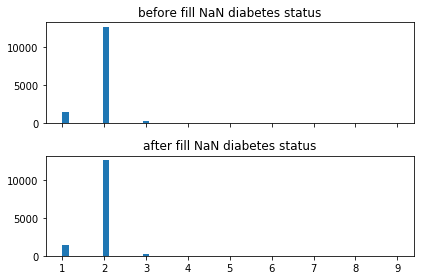

In [72]:
# df4 = df1 + df2 + df3 + dfs_db = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db
df4 = pd.merge(df3, dfs_db, on = 'SEQN', left_index =  True, sort = False)
# df4.info()
df4 = fill_NaN(df4,'diabetes status','mode') 
df4.info()

### Drug Use (du)

before filling NaN, valid entries of  ever use cocaine is  8300
after filling NaN, valid entries of  ever use cocaine is  9229
<class 'pandas.core.frame.DataFrame'>
Float64Index: 9229 entries, 5.0 to 31125.0
Data columns (total 17 columns):
gender                9229 non-null float64
age                   9229 non-null float64
race                  9229 non-null float64
FMincome              9229 non-null float64
education             9229 non-null float64
marital_status        9229 non-null float64
freq:12 drinks/yr?    9229 non-null float64
alco_freq_year        9229 non-null float64
pk use                9229 non-null float64
high BP               9229 non-null float64
high BC               9229 non-null float64
take med              9229 non-null float64
diet_status           9229 non-null int64
weight_status         9229 non-null int64
exercise_status       9229 non-null int64
diabetes status       9229 non-null float64
ever use cocaine      9229 non-null float64
dtypes: float64(1

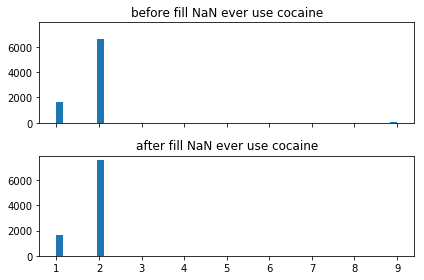

In [73]:
# Load drug use data
DUQ = pd.read_sas(datadir+'DUQ.XPT')
DUQ_B = pd.read_sas(datadir+'DUQ_B.XPT')
DUQ_C = pd.read_sas(datadir+'DUQ_C.XPT')
du_cols = ['SEQN', 'DUQ100']
du_renamed_cols = ['SEQN','ever use cocaine']
du_file_cols = [(DUQ,du_cols),(DUQ_B,du_cols),(DUQ_C,du_cols)]
dfs_du = concat_rename_dfs(du_file_cols,du_renamed_cols,"dfs_du.csv")

# df5 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du
df5 = pd.merge(df4, dfs_du, on = 'SEQN', left_index =  True, sort = False)
df5 = fill_NaN(df5,'ever use cocaine','mode') 
df5.info()

### Hospital Utilization & Access to Care (HUAC)

before filling NaN, valid entries of  health conditions is  9228
after filling NaN, valid entries of  health conditions is  9229
before filling NaN, valid entries of  health compared to a year ago is  9228
after filling NaN, valid entries of  health compared to a year ago is  9229
before filling NaN, valid entries of  visit to mental pro is  9228
after filling NaN, valid entries of  visit to mental pro is  9229
<class 'pandas.core.frame.DataFrame'>
Float64Index: 9229 entries, 5.0 to 31125.0
Data columns (total 20 columns):
gender                           9229 non-null float64
age                              9229 non-null float64
race                             9229 non-null float64
FMincome                         9229 non-null float64
education                        9229 non-null float64
marital_status                   9229 non-null float64
freq:12 drinks/yr?               9229 non-null float64
alco_freq_year                   9229 non-null float64
pk use                         

,gender,age,race,FMincome,education,marital_status,freq:12 drinks/yr?,alco_freq_year,pk use,high BP,high BC,take med,diet_status,weight_status,exercise_status,diabetes status,ever use cocaine,health conditions,health compared to a year ago,visit to mental pro
SEQN,,,,,,,,,,,,,,,,,,,,
5.0,1.0,49.0,3.0,11.000000,4.0,1.0,1.0,208.571429,3.0,1.0,1.0,1.0,1,0,1,2.0,2.0,2.0,3.0,2.0
7.0,2.0,59.0,4.0,8.742425,2.0,1.0,2.0,12.228571,3.0,1.0,1.0,1.0,1,1,1,2.0,2.0,1.0,3.0,1.0
10.0,1.0,43.0,4.0,99.000000,3.0,4.0,1.0,6.000000,1.0,2.0,2.0,2.0,1,1,1,2.0,2.0,3.0,1.0,1.0
12.0,1.0,37.0,3.0,11.000000,2.0,1.0,1.0,24.000000,2.0,1.0,2.0,1.0,1,0,0,2.0,1.0,4.0,3.0,2.0
15.0,2.0,38.0,3.0,8.000000,5.0,3.0,1.0,208.571429,4.0,2.0,1.0,1.0,1,1,1,2.0,2.0,3.0,3.0,1.0


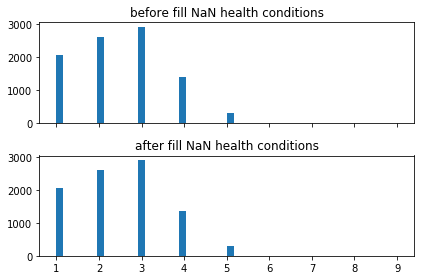

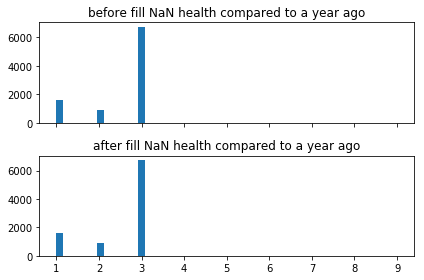

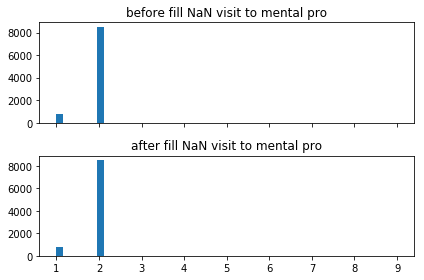

In [74]:
HUQ = pd.read_sas(datadir+'HUQ.XPT')
HUQ_B = pd.read_sas(datadir+'HUQ_B.XPT')
HUQ_C = pd.read_sas(datadir+'HUQ_C.XPT')
huac_cols = ['SEQN', 'HUQ010', 'HUQ020', 'HUQ090']
huac_renamed_cols = ['SEQN', 'health conditions', 'health compared to a year ago', 'visit to mental pro']
huac_file_cols = [(HUQ,huac_cols),(HUQ_B,huac_cols),(HUQ_C,huac_cols)]
dfs_huac = concat_rename_dfs(huac_file_cols,huac_renamed_cols,"dfs_huac.csv")

# df6 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac
df6 = pd.merge(df5, dfs_huac, on = 'SEQN', left_index =  True, sort = False)
df6_1 = fill_NaN(df6,'health conditions','mode') 
df6_2 = fill_NaN(df6_1,'health compared to a year ago','mode') 
df6_3 = fill_NaN(df6_2,'visit to mental pro','mode') 
df6 = df6_3
print(df6.info())
df6.head()

### Housing Characteristics (HC)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9229 entries, 5.0 to 31125.0
Data columns (total 22 columns):
gender                           9229 non-null float64
age                              9229 non-null float64
race                             9229 non-null float64
FMincome                         9229 non-null float64
education                        9229 non-null float64
marital_status                   9229 non-null float64
freq:12 drinks/yr?               9229 non-null float64
alco_freq_year                   9229 non-null float64
pk use                           9229 non-null float64
high BP                          9229 non-null float64
high BC                          9229 non-null float64
take med                         9229 non-null float64
diet_status                      9229 non-null int64
weight_status                    9229 non-null int64
exercise_status                  9229 non-null int64
diabetes status                  9229 non-null float64
ever use coc

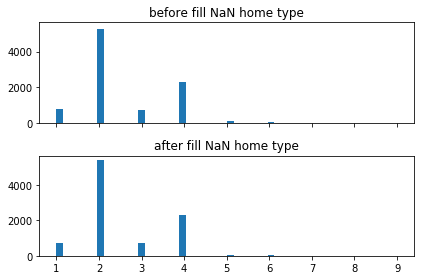

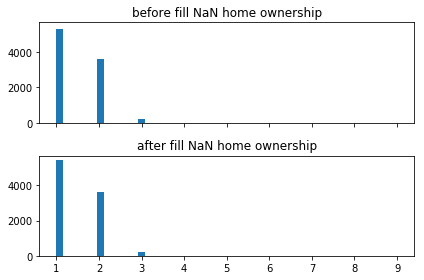

In [75]:
HOQ = pd.read_sas(datadir+'HOQ.XPT')
HOQ_B = pd.read_sas(datadir+'HOQ_B.XPT')
HOQ_C = pd.read_sas(datadir+'HOQ_C.XPT')
hc_cols_1 = ['SEQN', 'HOD010', 'HOQ065']
hc_cols_2 = ['SEQN', 'HOD011', 'HOQ065']
hc_renamed_cols = ['SEQN','home type','home ownership']
hc_file_cols = [(HOQ,hc_cols_1),(HOQ_B,hc_cols_1),(HOQ_C,hc_cols_2)]
dfs_hc = concat_rename_dfs(hc_file_cols,hc_renamed_cols,"dfs_hc.csv")

# df7 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc
df7 = pd.merge(df6, dfs_hc, on = 'SEQN', left_index =  True, sort = False)
print(df7.info())
get_NaN_ratio(df7,'home type')
df7_1 = fill_NaN(df7, 'home type', 'mode')
get_NaN_ratio(df7_1,'home ownership')
df7_2 = fill_NaN(df7_1, 'home ownership', 'mode')
df7 = df7_2

### Smoking (SM)
dreamalist major modifications:
1. For SMQ040, we find that the numbers of missing values are close to those who are light or non smokers. Hence, we simply substitute the nan values in 'SMQ040' with 3 (not currently smoking)????
       predict using random forest classifier

2. For 'SMD070' = 'sm daily freq',we substitute the missing values as 0 (as those who do not smoke now will not answer this question. making it a multi-class variable with 1 denoting heavy smokers, 2 denoting moderate smokers, and 3 denoting light smokers.????
       missing values not necessarily means non smokers. could due to high freq ?
       multi-class variable: see bear notes



<class 'pandas.core.frame.DataFrame'>
Float64Index: 15332 entries, 2.0 to 31125.0
Data columns (total 5 columns):
sm 100 cig?         15324 non-null float64
cur sm status       7391 non-null float64
sm daily freq       2708 non-null float64
sm yrs              2708 non-null float64
nicotine content    2837 non-null float64
dtypes: float64(5)
memory usage: 718.7 KB
None


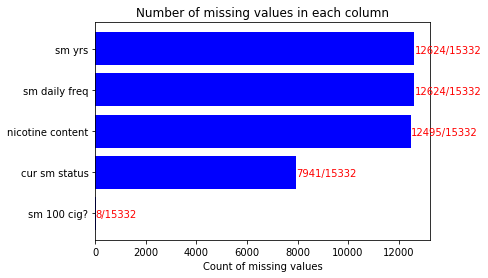

In [76]:
SMQ = pd.read_sas(datadir+'SMQ.XPT')
SMQ_B = pd.read_sas(datadir+'SMQ_B.XPT')
SMQ_C = pd.read_sas(datadir+'SMQ_C.XPT')
sm_cols = ['SEQN', 'SMQ020', 'SMQ040', 'SMD070', 'SMD075', 'SMD100NI']
sm_renamed_cols = ['SEQN','sm 100 cig?','cur sm status','sm daily freq','sm yrs','nicotine content']
sm_file_cols = [(SMQ,sm_cols),(SMQ_B,sm_cols),(SMQ_C,sm_cols)]
dfs_sm = concat_rename_dfs(sm_file_cols,sm_renamed_cols,"dfs_sm.csv")
print(dfs_sm.info())

plot_NaN_abundance(dfs_sm)


The NaN ratio in sm 100 cig? is 0.000
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  sm 100 cig? is  9227
after filling NaN, valid entries of  sm 100 cig? is  9229
The NaN ratio in cur sm status is 0.540
Since NaN ratio is large, predict NaN using ML...
Now call function: predict_NaN_with_ML(dfs,x,y,data_type,model)


Predict the missing values of cur sm status using  random forest  Classifier...
Features are: ['sm 100 cig?']
The number of predicted values: 4988
before filling NaN, valid entries of  cur sm status is  4241
after filling NaN, valid entries of  cur sm status is  9229

Predict the missing values of sm daily freq using  random forest  Regressor...
Features are: ['sm 100 cig?', 'cur sm status']
The number of predicted values: 7214
before filling NaN, valid entries of  sm daily freq is  2015
after filling NaN, valid entries of  sm daily freq is  9

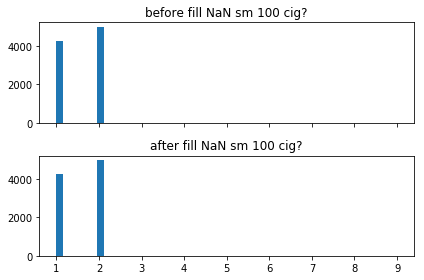

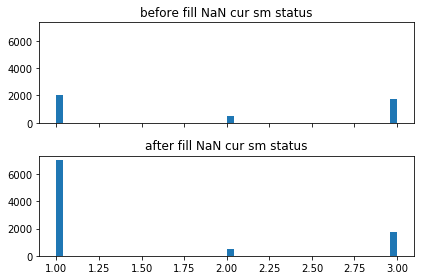

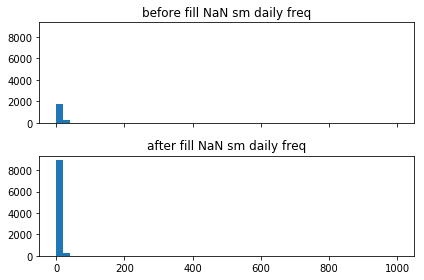

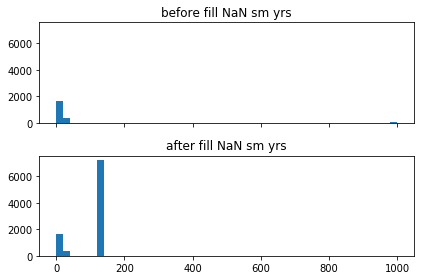

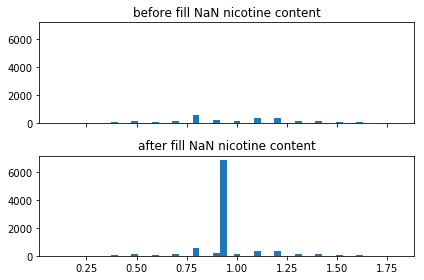

In [77]:
# df8 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc

df8 = pd.merge(df7, dfs_sm, on = 'SEQN', left_index =  True, sort = False)
get_NaN_ratio(df8,'sm 100 cig?')
df8_1 = fill_NaN(df8, 'sm 100 cig?', 'mode')
get_NaN_ratio(df8_1,'cur sm status')
# from above, we can easily tell that NaN ratio of x's other than 'sm 100 cig?' will be greater than 0.1
# predict NaN with ML for these x's
predict_NaN_with_ML(df8,['sm 100 cig?'],'cur sm status','categorical','random forest') 
predict_NaN_with_ML(df8,['sm 100 cig?','cur sm status'],'sm daily freq','numerical','random forest') 
predict_NaN_with_ML(df8,['sm 100 cig?','cur sm status','sm daily freq'],'sm yrs','numerical','random forest')
predict_NaN_with_ML(df8,['sm 100 cig?','cur sm status','sm daily freq','sm yrs'],'nicotine content','numerical','random forest')

print(df8.info())


### Occupation (OC)

questions:
1. 'weekly work hrs' - 
    1. "Because people without work or has not worked last week tend not to answer this question. We replace the missing and 7/9 values in this variable with 0" 这个变量的取值范围是1 to 160，让missing values都变成1？ 尽量小？
    2. convert to multivariable?



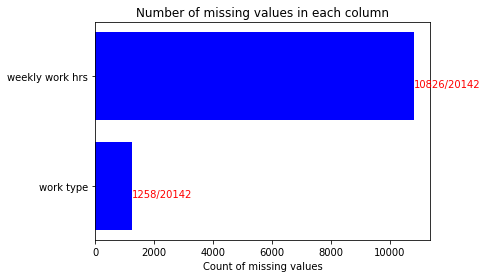

The NaN ratio in work type is 0.062
Since NaN ratio is small, fill NaN directly with fill type: mode, mean, new category
Now call function: fill_NaN(dfs, col_name, fill_type)

before filling NaN, valid entries of  work type is  18884
after filling NaN, valid entries of  work type is  20142

Predict the missing values of weekly work hrs using  random forest  Regressor...
Features are: ['work type']
The number of predicted values: 10826
before filling NaN, valid entries of  weekly work hrs is  9316
after filling NaN, valid entries of  weekly work hrs is  20142
<class 'pandas.core.frame.DataFrame'>
Float64Index: 9229 entries, 5.0 to 31125.0
Data columns (total 29 columns):
gender                           9229 non-null float64
age                              9229 non-null float64
race                             9229 non-null float64
FMincome                         9229 non-null float64
education                        9229 non-null float64
marital_status                   9229 non-null

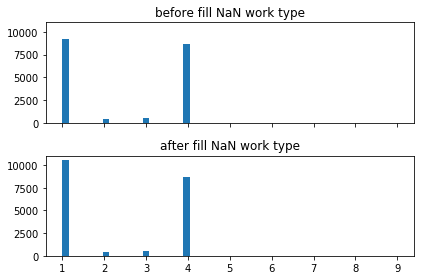

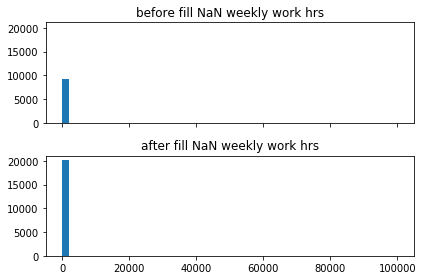

In [78]:
OCD = pd.read_sas(datadir+'OCQ.XPT')
OCD_B = pd.read_sas(datadir+'OCQ_B.XPT')
OCD_C = pd.read_sas(datadir+'OCQ_C.XPT')
OCD_cols = ['SEQN', 'OCQ150', 'OCQ180']
OCD_B_cols = ['SEQN', 'OCD150', 'OCD180']
OCD_C_cols = ['SEQN', 'OCD150', 'OCQ180']
oc_renamed_cols = ['SEQN','work type','weekly work hrs']
oc_file_cols = [(OCD,OCD_cols),(OCD_B,OCD_B_cols),(OCD_C,OCD_C_cols)]
dfs_oc = concat_rename_dfs(oc_file_cols,oc_renamed_cols,"dfs_oc.csv")

plot_NaN_abundance(dfs_oc)
get_NaN_ratio(dfs_oc,'work type')
dfs_oc = fill_NaN(dfs_oc, 'work type', 'mode')
predict_NaN_with_ML(dfs_oc,['work type'],'weekly work hrs','numerical','random forest')

# df9 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc + dfs_oc
df9 = pd.merge(df8, dfs_oc, on = 'SEQN', left_index =  True, sort = False)
df9.info()

### Physical Activity - Individual Activities (PA)

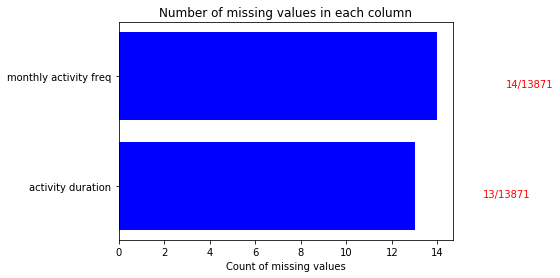

before filling NaN, valid entries of  monthly activity freq is  13857
after filling NaN, valid entries of  monthly activity freq is  13871
before filling NaN, valid entries of  activity duration is  13858
after filling NaN, valid entries of  activity duration is  13871
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5509 entries, 5.0 to 31116.0
Data columns (total 32 columns):
gender                           5509 non-null float64
age                              5509 non-null float64
race                             5509 non-null float64
FMincome                         5509 non-null float64
education                        5509 non-null float64
marital_status                   5509 non-null float64
freq:12 drinks/yr?               5509 non-null float64
alco_freq_year                   5509 non-null float64
pk use                           5509 non-null float64
high BP                          5509 non-null float64
high BC                          5509 non-null float64
take med   

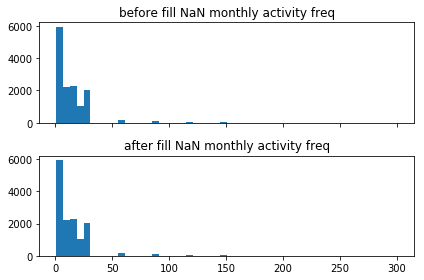

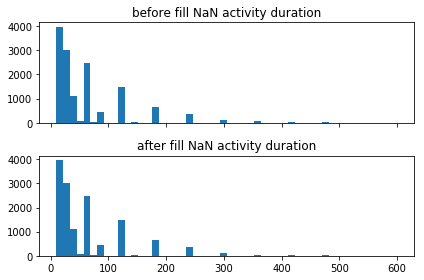

In [79]:
PAQIAF = pd.read_sas(datadir+'PAQIAF.XPT')
PAQIAF_B = pd.read_sas(datadir+'PAQIAF_B.XPT')
PAQIAF_C = pd.read_sas(datadir+'PAQIAF_C.XPT')
PAQIAF_cols = ['SEQN','PADLEVEL','PADTIMES','PADDURAT']
pa_renamed_cols = ['SEQN','activity level','monthly activity freq','activity duration']
pa_file_cols = [(PAQIAF,PAQIAF_cols),(PAQIAF_B,PAQIAF_cols),(PAQIAF_C,PAQIAF_cols)]
dfs_pa = concat_rename_dfs(pa_file_cols,pa_renamed_cols,"dfs_pa.csv")

plot_NaN_abundance(dfs_pa)
# activity level has no NaN, the other two have very few
dfs_pa_1 = fill_NaN(dfs_pa, 'monthly activity freq', 'mode')
dfs_pa_2 = fill_NaN(dfs_pa_1, 'activity duration', 'mode')
dfs_pa = dfs_pa_2

# df10 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc + dfs_oc + dfs_pa
df10 = pd.merge(df9, dfs_pa, on = 'SEQN', left_index =  True, sort = False)
df10.info()

### Weight history (WH)

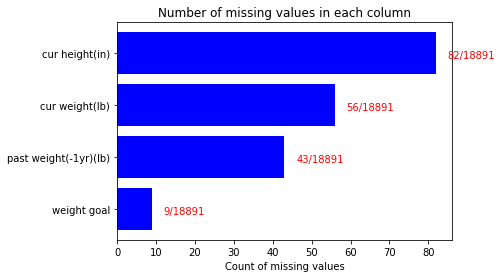

before filling NaN, valid entries of  cur height(in) is  18809
after filling NaN, valid entries of  cur height(in) is  18891
before filling NaN, valid entries of  cur weight(lb) is  18835
after filling NaN, valid entries of  cur weight(lb) is  18891
before filling NaN, valid entries of  weight goal is  18882
after filling NaN, valid entries of  weight goal is  18891
before filling NaN, valid entries of  past weight(-1yr)(lb) is  18848
after filling NaN, valid entries of  past weight(-1yr)(lb) is  18891


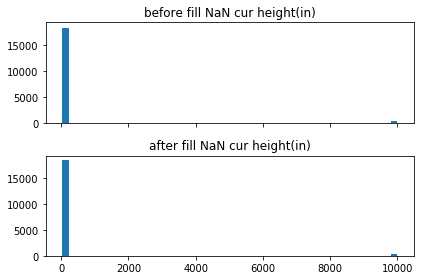

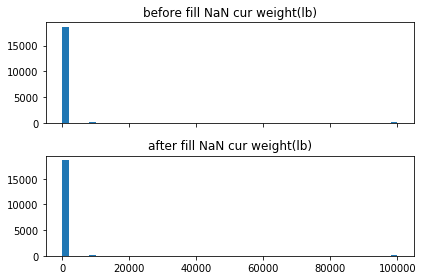

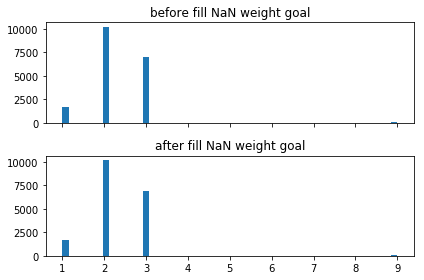

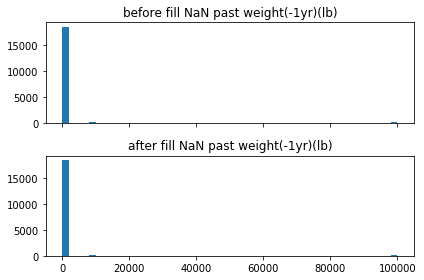

In [80]:
WHQ = pd.read_sas(datadir+'WHQ.XPT')
WHQ_B = pd.read_sas(datadir+'WHQ_B.XPT')
WHQ_C = pd.read_sas(datadir+'WHQ_C.XPT')
WHQ_cols = ['SEQN', 'WHD010', 'WHD020','WHD040', 'WHD050']
WHQ_B_cols = ['SEQN', 'WHD010', 'WHD020','WHQ040', 'WHD050']
WHQ_C_cols = ['SEQN', 'WHD010', 'WHD020','WHQ040', 'WHD050']
wh_renamed_cols = ['SEQN','cur height(in)','cur weight(lb)','weight goal','past weight(-1yr)(lb)']
wh_file_cols = [(WHQ,WHQ_cols),(WHQ_B,WHQ_B_cols),(WHQ_C,WHQ_C_cols)]
dfs_wh = concat_rename_dfs(wh_file_cols,wh_renamed_cols,"dfs_wh.csv")

plot_NaN_abundance(dfs_wh)
# fill all with modes since NaN are very few
dfs_wh_1 = fill_NaN(dfs_wh, 'cur height(in)', 'mode')
dfs_wh_2 = fill_NaN(dfs_wh_1, 'cur weight(lb)', 'mode')
dfs_wh_3 = fill_NaN(dfs_wh_2, 'weight goal', 'mode')
dfs_wh_4 = fill_NaN(dfs_wh_3, 'past weight(-1yr)(lb)', 'mode')
dfs_wh = dfs_wh_4

1. Group 'cur height(in)' and 'cur weight(lb)' into BMI
        BMI = weight(lb)/(height(in)^2)*703
2. Group 'cur weight(lb)' and 'past weight(-1yr)(lb)' into weight change: change of weight from last year to this year
        weight change = (cur weight)/(past weight)
        weight change > 1: weight gain
        weight change < 1: weight loss
        * use ratio instead of (cur weight) - (past weight) to avoid negative values
3. Categorize 'weight change' from step 2 into a 3 values variables: see table in step 4

4. Group weight change obtained from previous step and weight goal into weight_goal_outcome: what's the goalion of the weight and what's the actual resulting weight change? 

| weight goal               | weight change                 |
|---------------------------|-------------------------------|
| 1 - want to gain          | 1 - gain: > 1.1               |
| 2 - want to lose          | 2 - loss: < 0.9               |
| 3 - want to stay the same | 3 - about the same: 0.9 ~ 1.1 |

* For this new variable 'weight_goal_outcome': 
    * 1 means Yes - successfully achieve weight goal & goal matches with actual result; goal = change
    * 2 means NO - fails to achieve weight goal 

| (weight goal, weight change) code   | weight_goal_change code |
|-------------------------------------|---------------------------|
| 1,1                                 | 1                         |
| 1,2                                 | 2                         |
| 1,3                                 | 2                         |
| 2,1                                 | 1                         |
| 2,2                                 | 2                         |
| 2,3                                 | 2                         |
| 3,1                                 | 2                         |
| 3,2                                 | 2                         |
| 3,3                                 | 1                         |

In [81]:
# step 1. Group 'cur height(in)' and 'cur weight(lb)' into BMI
dfs_wh['BMI'] = dfs_wh['cur weight(lb)']/((dfs_wh['cur height(in)'])**2) * 703

# step 2. Create weight change variable from cur weight & past weight
dfs_wh['weight change'] = dfs_wh['cur weight(lb)']/dfs_wh['past weight(-1yr)(lb)']

# step 3. Categorize 'weight change category'('wcc') from step 2 into a 3 values variables
dfs_wh['weight change(category)'] = 0
dfs_wh['weight change(category)'][dfs_wh['weight change'] > 1.1] = 1 # weight gain
dfs_wh['weight change(category)'][dfs_wh['weight change'] < 0.9] = 2 # weight loss
dfs_wh['weight change(category)'][(dfs_wh['weight change'] >= 0.9) & (dfs_wh['weight change'] <= 1.1)] = 3 # weight stays the same


# step 4. Create weight_goal_outcome based on weight change(category) and weight goal
dfs_wh['weight goal outcome'] = 2 # initialize the col with 2 
dfs_wh['weight goal outcome'][dfs_wh['weight change(category)'] == dfs_wh['weight goal'] ] = 1 # change to 1 if find matches

dfs_wh = dfs_wh.drop(['cur height(in)','cur weight(lb)','past weight(-1yr)(lb)','weight change','weight change(category)','weight goal'], axis=1)
dfs_wh.head(20)

,BMI,weight goal outcome
SEQN,,
2.0,24.806553,1
5.0,28.728030,2
6.0,22.655273,2
7.0,29.284734,2
10.0,24.995556,2
12.0,31.850204,2
13.0,24.126627,1
14.0,28.286391,2
15.0,25.101869,2


In [82]:
# df11 = (dfs_demo + dfs_alco) + dfs_pk + dfs_bp + dfs_db + dfs_du + dfs_huac + dfs_hc + dfs_oc + dfs_pa + dfs_wh
df11 = pd.merge(df10, dfs_wh, on = 'SEQN', left_index =  True, sort = False)
df11.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5509 entries, 5.0 to 31116.0
Data columns (total 34 columns):
gender                           5509 non-null float64
age                              5509 non-null float64
race                             5509 non-null float64
FMincome                         5509 non-null float64
education                        5509 non-null float64
marital_status                   5509 non-null float64
freq:12 drinks/yr?               5509 non-null float64
alco_freq_year                   5509 non-null float64
pk use                           5509 non-null float64
high BP                          5509 non-null float64
high BC                          5509 non-null float64
take med                         5509 non-null float64
diet_status                      5509 non-null int64
weight_status                    5509 non-null int64
exercise_status                  5509 non-null int64
diabetes status                  5509 non-null float64
ever use coc

# Process Y - Mental health data
For all three types of mental problems, 
- 1: Positive Diagnosis - has mental problems
- 5: Negative Diagnosis - does not have mental problems

### Mental Health - Panic Disorder (PD)

In [83]:
CIQPANIC = pd.read_sas(datadir+'CIQPANIC.XPT')
CIQPANIC_B = pd.read_sas(datadir+'CIQPAN_B.XPT')
CIQPANIC_C = pd.read_sas(datadir+'CIQPAN_C.XPT')
CIQPANIC_cols = ['SEQN', 'CIDPSCOR']
pd_renamed_cols = ['SEQN', 'Panic Disorder Diagnosis']
pd_file_cols = [(CIQPANIC,CIQPANIC_cols),(CIQPANIC_B,CIQPANIC_cols),(CIQPANIC_C,CIQPANIC_cols)]
dfs_pd = concat_rename_dfs(pd_file_cols,pd_renamed_cols,"dfs_pd.csv")

### Mental Health - Generalized Anxiety Disorder (AD)

In [84]:
CIQGAD = pd.read_sas(datadir+'CIQGAD.XPT')
CIQGAD_B = pd.read_sas(datadir+'CIQGAD_B.XPT')
CIQGAD_C = pd.read_sas(datadir+'CIQGAD_C.XPT')
CIQGAD_cols = ['SEQN', 'CIDGSCOR']
ad_renamed_cols = ['SEQN', 'Anxiety Disorder Diagnosis']
ad_file_cols = [(CIQGAD,CIQGAD_cols),(CIQGAD_B,CIQGAD_cols),(CIQGAD_B,CIQGAD_cols)]
dfs_ad = concat_rename_dfs(ad_file_cols,ad_renamed_cols,"dfs_ad.csv")

### Mental Health - Depression (DPS)

In [85]:
CIQDEP = pd.read_sas(datadir+'CIQMDEP.XPT')
CIQDEP_B = pd.read_sas(datadir+'CIQDEP_B.XPT')
CIQDEP_C = pd.read_sas(datadir+'CIQDEP_C.XPT')
CIQDEP_cols = ['SEQN', 'CIDDSCOR']
dps_renamed_cols = ['SEQN','Depression Diagnosis']
dps_file_cols = [(CIQDEP,CIQDEP_cols),(CIQDEP_B,CIQDEP_cols),(CIQDEP_C,CIQDEP_cols)]
dfs_dps = concat_rename_dfs(dps_file_cols,dps_renamed_cols,"dfs_dps.csv")

1. Merge all mental health files into dfy
2. Dropped NaN entries
3. Replace all 5 (negative diagnosis) with 2 to be consistent with categorical x's before
    - 1: True (positive)
    - 2: False (negative)

In [86]:
dfy1 = pd.merge(dfs_pd, dfs_ad, on = 'SEQN', left_index = True, sort = False)
dfy2 = pd.merge(dfy1, dfs_dps, on = 'SEQN', left_index = True, sort = False)
dfy = dfy2.dropna()
print('Before dropping NaN, the number of entries is: ',dfy2.shape[0])
print('After dropping NaN, the number of entries is: ',dfy.shape[0])
dfy = dfy.replace(5, 2)
dfy.info()

Before dropping NaN, the number of entries is:  1706
After dropping NaN, the number of entries is:  1525
<class 'pandas.core.frame.DataFrame'>
Float64Index: 1525 entries, 12.0 to 20925.0
Data columns (total 3 columns):
Panic Disorder Diagnosis      1525 non-null float64
Anxiety Disorder Diagnosis    1525 non-null float64
Depression Diagnosis          1525 non-null float64
dtypes: float64(3)
memory usage: 47.7 KB
